<a href="https://colab.research.google.com/github/rahulsm27/ML/blob/main/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

from torch import nn, optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [60]:
from torch.utils.data import DataLoader


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0,1)])
# Load the MNIST dataset
mnist_dataset_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Load the MNIST dataset
mnist_dataset_test = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_dataset_train,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_dataset_test,batch_size=batch_size, shuffle=True)


In [61]:
latent_dim = 64
categorical_dim = 2



In [62]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
      # Add noise to the images
        noise_factor = 0.5
        x_noise = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)

        self.noise = torch.randn(x.shape)
        x_noise = x + self.noise
        h1 = self.relu(self.fc1(x_noise))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x):
        q = self.encode(x.view(-1, 784))
        #print (q.size)
      #  q_y = q.view(q.size(0), latent_dim, categorical_dim)
        return self.decode(q)

In [63]:
# # Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(recon_x, x, qy):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False) / x.shape[0]

#     log_ratio = torch.log(qy * categorical_dim + 1e-20)
#     KLD = torch.sum(qy * log_ratio, dim=-1).mean()

#     return BCE + KLD

In [64]:

def train(epoch, model, train_loader, optimizer,  cuda=True):
  model.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data.to(device)
    optimizer.zero_grad()

    recon_batch = model(data)
    loss = criterion(recon_batch, data.view(data.size(0),-1).to(device) )
    loss.backward()

    train_loss += loss.item() * len(data)
    optimizer.step()


    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item()))

  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [65]:
epochs = 10

model = DAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


In [66]:
for epoch in range(1, epochs + 1):
    train(epoch, model, train_loader, optimizer, True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.232310
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.056926
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.051320
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.043771
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.046770
====> Epoch: 1 Average loss: 0.0518
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042626
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.042446
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.039057
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.039950
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.040982
====> Epoch: 2 Average loss: 0.0413
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.041841
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.039737
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.040195
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.040779
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.040951
====> Epoch: 3 Average loss: 0.0397
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.037971
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.037652
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.038853
Train Epoch:

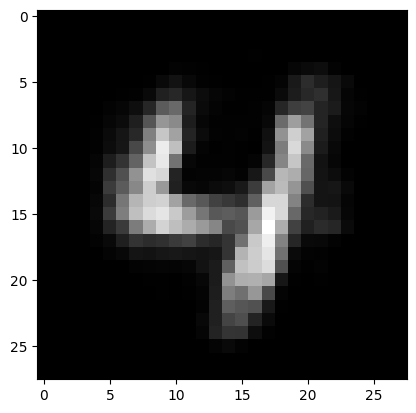

In [72]:
import matplotlib.pyplot as plt




x_test = torch.randn(128).to(device)
denoised_images = model.decode(x_test)*255
# Display the first image in the denoised test set
plt.imshow(denoised_images.view(28,28).detach().numpy(), cmap='gray')
plt.show()